In [72]:
import pandas as pd
import json
import torch
import torch.nn.functional as F
from loguru import logger
import sys
import os
from tqdm import tqdm

import numpy as np
from torch_geometric.data import Data

from core.LLM.LLMEncoder import LLMEncoder
from core.ToTorch.DataBuilder import QADataBuilder, QAMaskBuilder
from config.config import (
    TRIPLES_PATH,
    ENTITIES_LABELS_PATH,
    PROPERTIES_LABELS_PATH,
    GRAPH_EMBEDDINGS_PATH,
    QUESTIONS_ANSWERS_PATH,
    QUESTIONS_EMBEDDINGS_PATH,
    QUESTIONS_CONCEPTS_ANSWERS_PATH,
    GRAPH_EMBEDDINGS_WITH_COMMENT_PATH,
    EXPERIMENT_RESULTS_PATH,

    TRIPLES_PATH_OLD,
    ENTITIES_LABELS_PATH_OLD,
    PROPERTIES_LABELS_PATH_OLD,
    GRAPH_EMBEDDINGS_PATH_OLD,
    QUESTIONS_CONCEPTS_ANSWERS_PATH,
    GRAPH_EMBEDDINGS_PATH_OLD
)

from core.NeuralNet.GNN import GCN,RGCN
NUM_EPOCHS=1

In [ ]:
logger.remove()
logger.add(sys.stderr, level="DEBUG")

## CREATE DATA
logger.info("Creating Data object")

qa_data_builder = QADataBuilder(
    triples_path=TRIPLES_PATH,
    entities_labels_path=ENTITIES_LABELS_PATH,
    properties_labels_path=PROPERTIES_LABELS_PATH,
    embeddings_path=GRAPH_EMBEDDINGS_PATH,
    questions_answers_path=QUESTIONS_ANSWERS_PATH,
    questions_embeddings_path=QUESTIONS_EMBEDDINGS_PATH,
)

x = qa_data_builder.get_x()
train_mask, test_mask, val_mask = qa_data_builder.get_questions_masks()
NUM_EPOCHS_PER_QUESTION = int(NUM_EPOCHS / sum(train_mask))

## TRAIN MLP
logger.info("Training MLP")
model = MLP(
    num_node_features=(2 * x.shape[1]), dim_hidden_layer=16, num_classes=2
)  # we multiply x.shape by two so as to account for question embedding
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.train()

for q_index, question_embedding in enumerate(
    qa_data_builder.questions_embeddings_masked(train_mask)
):  # call the questions_iterator from the instance
    question, q_embedding = question_embedding
    q_x = qa_data_builder.get_x(
        to_concat=q_embedding
    )  # add question embedding to node features embedding
    q_y = qa_data_builder.get_y(question=question)
    data = Data(x=q_x, y=q_y)
    if not data.validate():
        logger.error(f"Data object is not valid for question {question}")

    for epoch in range(NUM_EPOCHS_PER_QUESTION):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y, weight = torch.tensor([0.000001, 1-0.000001]))
        loss.backward()
        optimizer.step()
    logger.debug(
        f"Total Question: {(q_index + 1)}, Total Epochs: {NUM_EPOCHS_PER_QUESTION * (q_index + 1):3d}, Loss: {loss:.4f}"
    )

In [ ]:
def _predict_answer(model, data):
    """
    Returns the predicted answer and node index.
    """
    return model(data).max(dim=1)[0].argmax().item()

def evaluate_qa_model(model, qa_data_builder, mask):
    model.eval()
    correct_predictions = 0
    for q_index, question_embedding in enumerate(
        qa_data_builder.questions_embeddings_masked(mask)
    ):
        question, q_embedding = question_embedding
        x_q = qa_data_builder.get_x(
            to_concat=q_embedding
        )  # adding the question embedding to the node embeddings
        y_q = qa_data_builder.get_y(question=question)
        data = Data(x=x_q, edge_index=qa_data_builder.get_edge_index(), y=y_q)
        pred_node_idx = _predict_answer(model, data)
        actual_node_idx = qa_data_builder.get_node_index_for_question_answer(question)
        if pred_node_idx == actual_node_idx:
            logger.debug(f"Correctly predicted answer to question {question}.")
            correct_predictions += 1
        elif pred_node_idx != torch.tensor(0):
            logger.debug(
                f"Question: {question}. Predicted answer = {qa_data_builder.index_to_entity[pred_node_idx]}, Actual answer: {qa_data_builder.index_to_entity[actual_node_idx]}"
            )
        else:
            logger.debug(f"Could not predict any answer")
    return correct_predictions / (q_index + 1)

In [ ]:
evaluate_qa_model(model=model, qa_data_builder=qa_data_builder, mask=train_mask)

## QA Training

In [67]:
# Build data
logger.remove()
logger.add(sys.stderr, level="DEBUG")

## CREATE DATA
logger.info("Creating Data object")

qa_data_builder = QAMaskBuilder(
    triples_path=TRIPLES_PATH_OLD,
    entities_labels_path=ENTITIES_LABELS_PATH_OLD,
    properties_labels_path=PROPERTIES_LABELS_PATH_OLD,
    embeddings_path=GRAPH_EMBEDDINGS_PATH_OLD,
    questions_concepts_answers_path=QUESTIONS_CONCEPTS_ANSWERS_PATH,
    questions_embeddings_path = QUESTIONS_EMBEDDINGS_PATH
    
)

2023-08-25 14:14:10.946 | INFO     | __main__:<module>:6 - Creating Data object


In [5]:
data = qa_data_builder.build_data()
data

Data(x=[29025, 768], edge_index=[2, 145402], edge_type=[145402])

In [11]:
# TRAIN GNN
logger.info("Training GNN")
model = GCN(
    num_node_features=data.num_node_features*2, dim_hidden_layer=16,num_layers=1, num_classes=2
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)

2023-08-23 15:46:19.736 | INFO     | __main__:<module>:2 - Training GNN


In [8]:
qa_subgraph_info = []
for idx, row in tqdm(qa_data_builder.question_concepts_answers.iterrows()):

    q_edge_mask, q_nodes, q_concept_mask, q_answer_mask, q_answer_and_random_nodes_mask =qa_data_builder.get_concepts_and_masks_for_question(question =row["question"], concept_uri= row["concepts"], answer_uri= row["answers"])
    q_edge_index = data.edge_index[:,q_edge_mask]
    q_edge_type = data.edge_type[q_edge_mask]
    q_training_x_mask = qa_data_builder.get_question_training_mask_for_x()
    q_y_labels = qa_data_builder.get_question_y_labels()
    qa_subgraph_info.append({"q_idx":idx,"q":row["question"],"q_pattern_id":row["pattern_id"],"q_edge_mask":q_edge_mask, "q_nodes":q_nodes, "q_concept_mask":q_concept_mask, "q_answer_mask":q_answer_mask, "q_answer_and_random_nodes_mask":q_answer_and_random_nodes_mask,"q_edge_index":q_edge_index,"q_edge_type":q_edge_type,"q_training_x_mask":q_training_x_mask,"q_y_labels":q_y_labels})


2705it [00:20, 134.57it/s]


In [9]:
qa_subgraph_info[0]

{'q_idx': 0,
 'q': 'What is the type of Incentive and Commission Management (S/4 CLD)?',
 'q_pattern_id': 0,
 'q_edge_mask': tensor([False, False, False,  ..., False, False, False]),
 'q_nodes': tensor([19002, 19274, 19288,  ..., 22920, 28976, 29023]),
 'q_concept_mask': tensor([False, False, False,  ..., False, False, False]),
 'q_answer_mask': tensor([False, False, False,  ..., False, False, False]),
 'q_answer_and_random_nodes_mask': tensor([False, False, False,  ..., False, False, False]),
 'q_edge_index': tensor([[22581, 19460, 19460,  ..., 22094, 19460, 20833],
         [28976, 19710, 19332,  ..., 22579, 19288, 22581]]),
 'q_edge_type': tensor([ 86,  62,  67,  ..., 192, 192, 192]),
 'q_training_x_mask': tensor([False, False, False,  ..., False, False, False]),
 'q_y_labels': tensor([0, 0, 0,  ..., 0, 0, 0])}

In [13]:
# No of questions that have answer node within it
count_answers_in_subgraph = 0
for item in tqdm(qa_subgraph_info):
    if sum(item["q_answer_mask"])>0:
        count_answers_in_subgraph += 1
count_answers_in_subgraph

100%|██████████| 2705/2705 [00:08<00:00, 316.06it/s] 


2594

In [10]:
pattern_id_q_idx_node_count  = []
for idx, item in tqdm(enumerate(qa_subgraph_info)):
    node_count = len(item["q_nodes"])
    pattern_id = item['q_pattern_id']
    q_idx = item['q_idx']
    pattern_id_q_idx_node_count.append((pattern_id,q_idx,node_count))

2705it [00:00, 450758.53it/s]


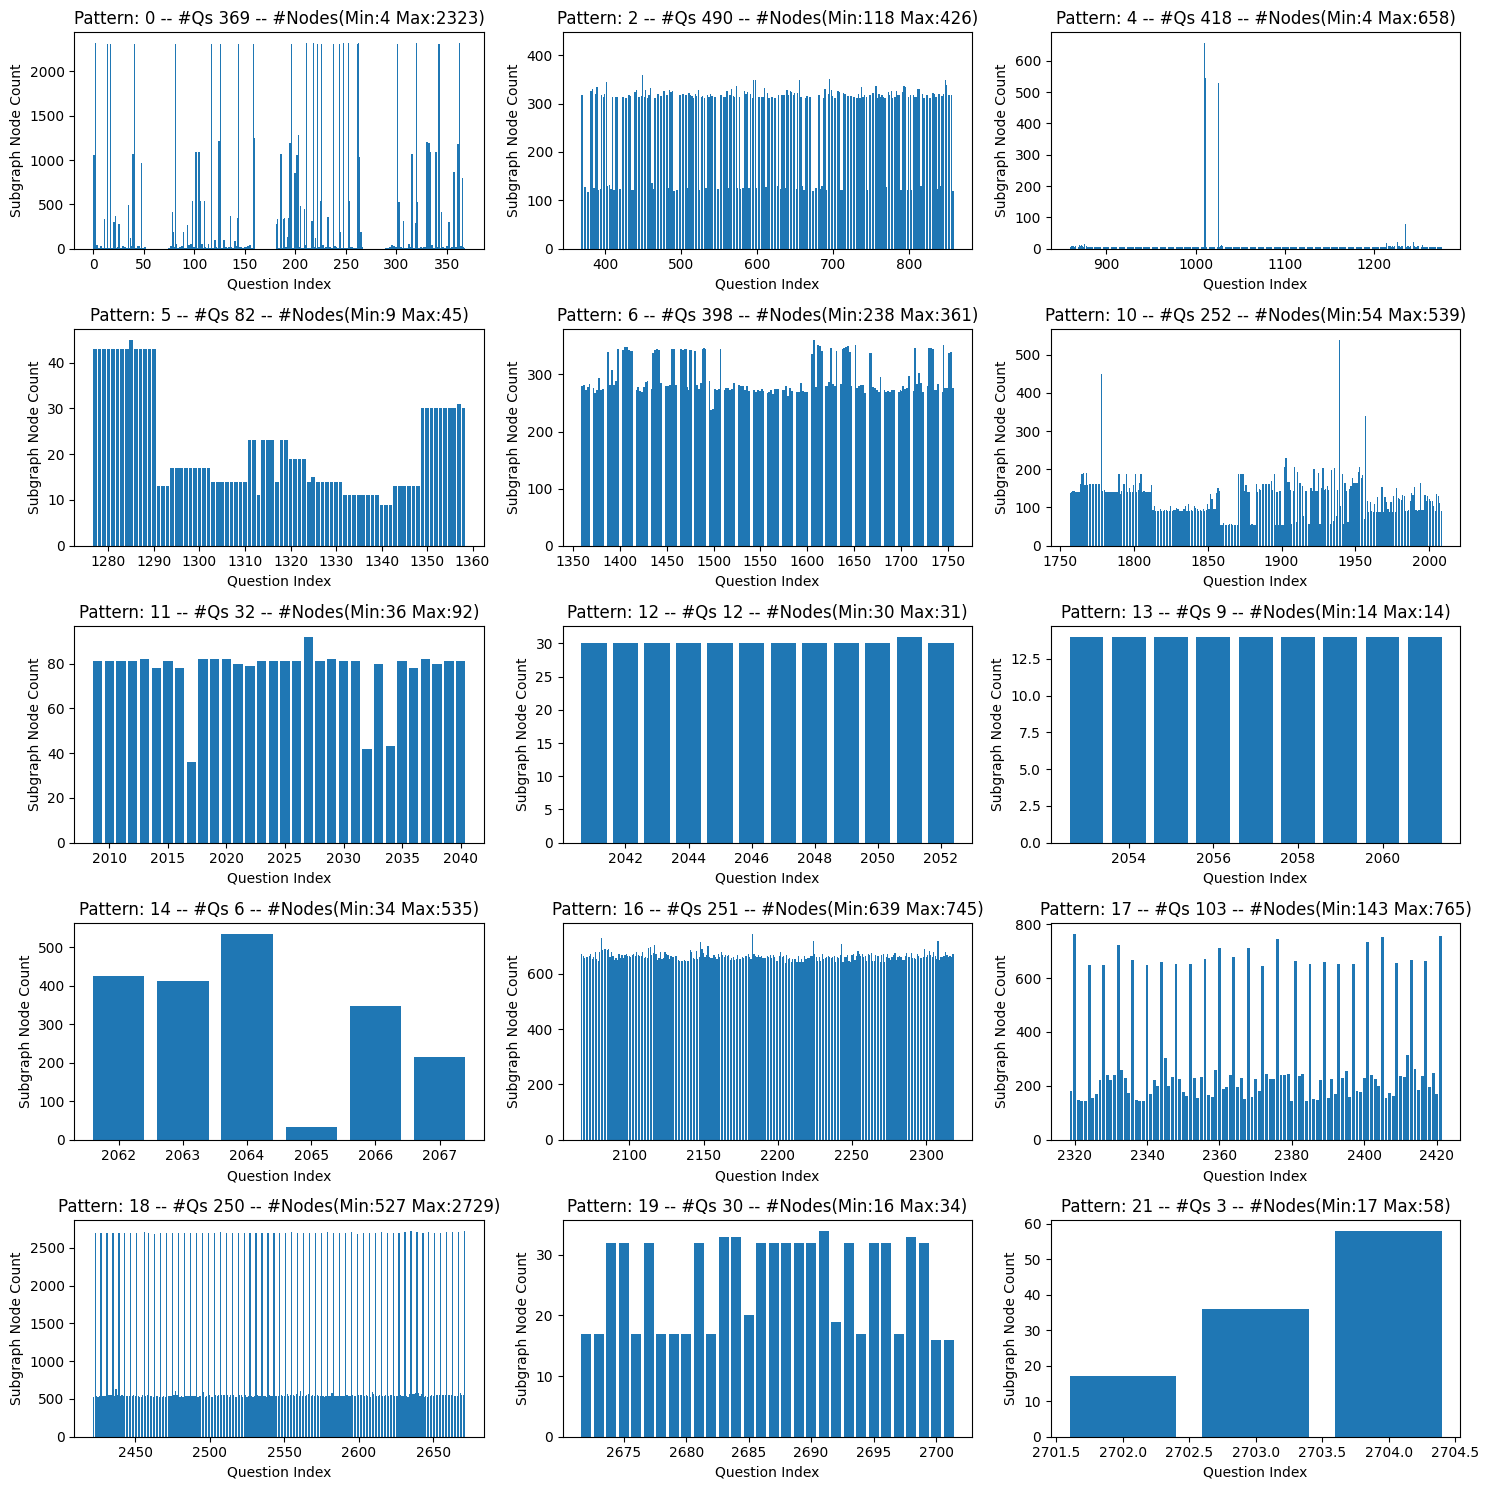

In [58]:
import matplotlib.pyplot as plt
from collections import defaultdict

counts = defaultdict(dict)

for pattern_id, question_index, nodes_in_question in pattern_id_q_idx_node_count:
    counts[pattern_id][question_index]= nodes_in_question

# Create subplots with 5 plots per row and 3 rows
num_patterns = len(counts)
rows = 5
cols = num_patterns // rows + (1 if num_patterns % rows > 0 else 0)
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

# Create plots for each pattern_id
for i, (pattern_id, question_counts) in enumerate(counts.items()):

    row = i // cols
    col = i % cols
    x = list(question_counts.keys())
    y = list(question_counts.values())

    ax = axes[row, col]
    ax.bar(x, y)
    ax.set_xlabel('Question Index')
    ax.set_ylabel('Subgraph Node Count')
    ax.set_title(f'Pattern: {pattern_id} -- #Qs {len(question_counts)} -- #Nodes(Min:{min(y)} Max:{max(y)})')

plt.tight_layout()
plt.show()



In [61]:
subgraph_node_count = [element[2] for element in pattern_id_q_idx_node_count ]

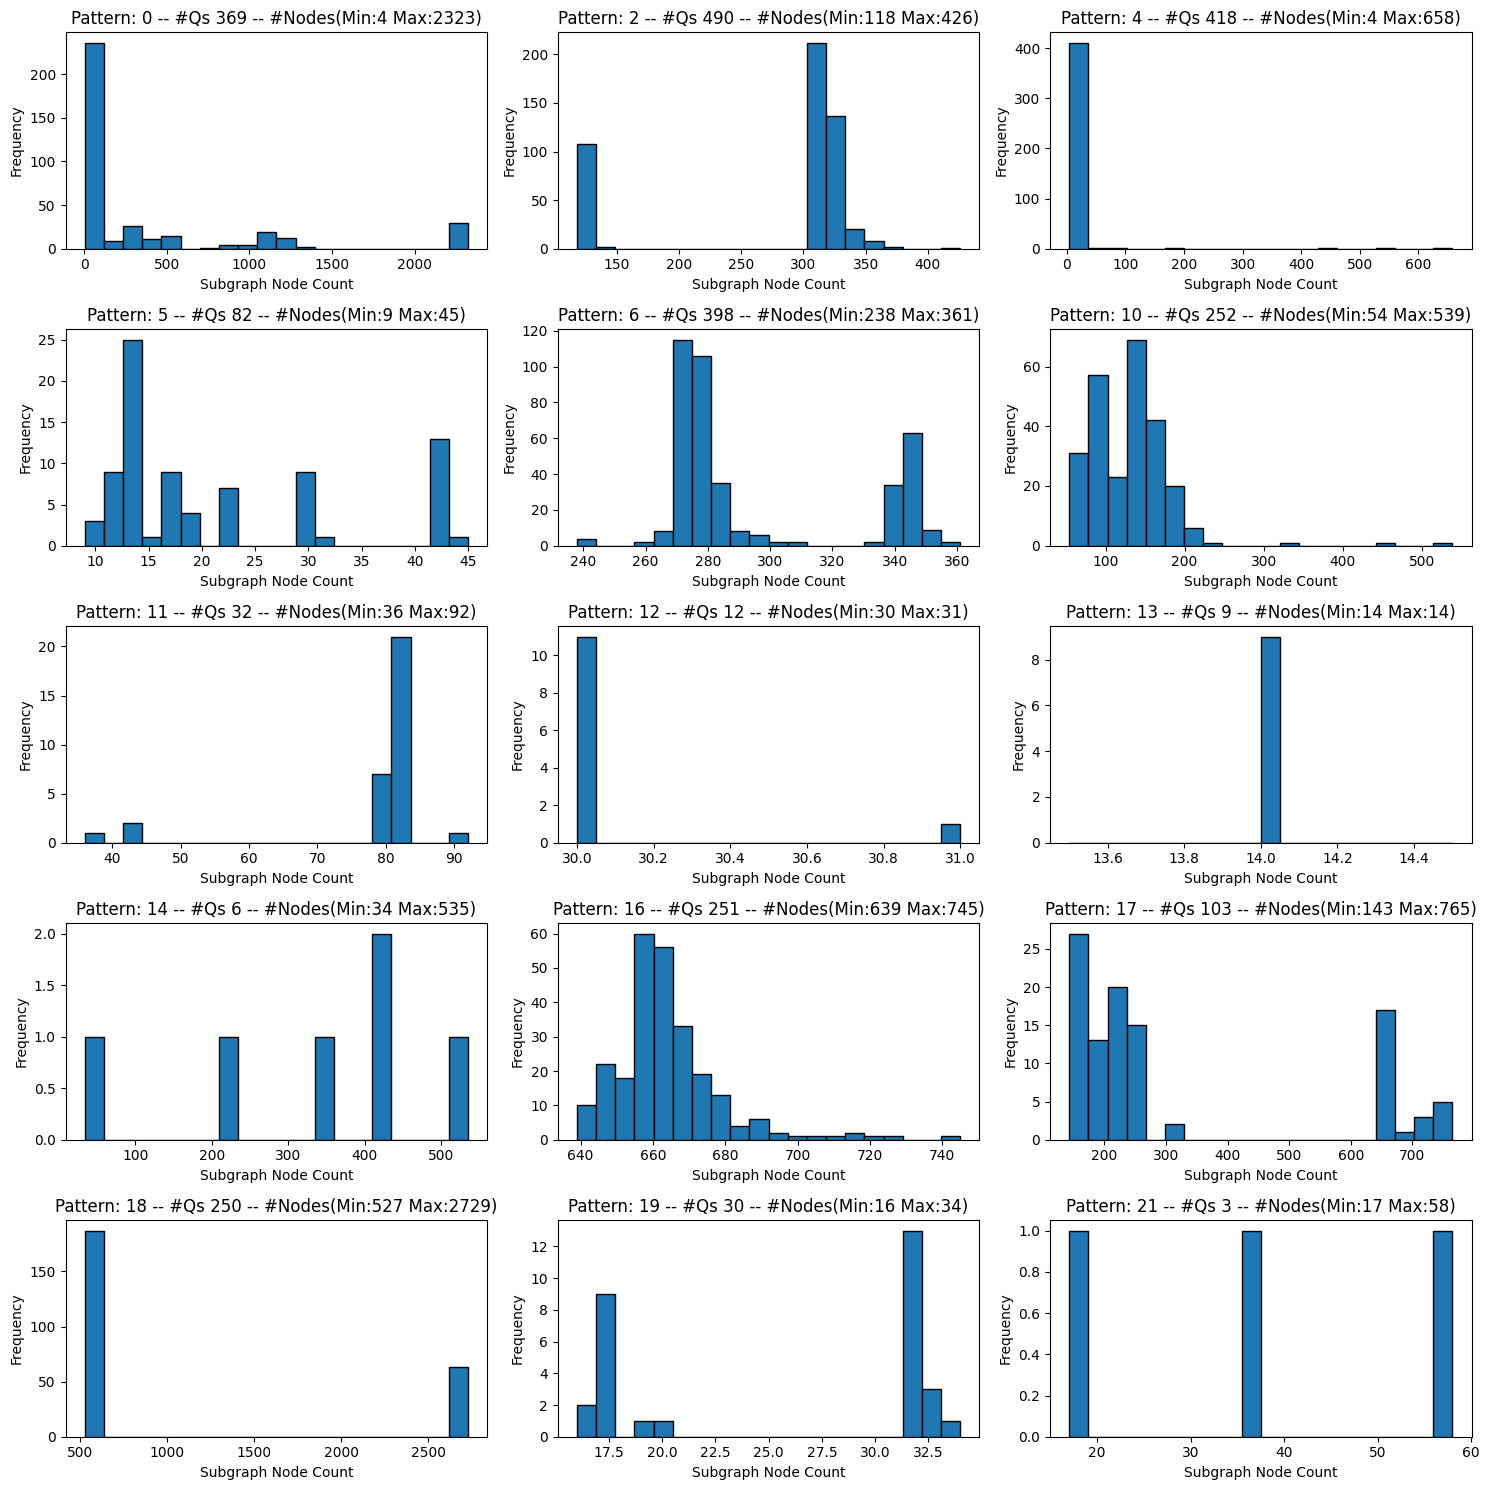

In [65]:
# Create subplots with 5 plots per row and 3 rows
num_patterns = len(counts)
rows = 5
cols = num_patterns // rows + (1 if num_patterns % rows > 0 else 0)
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

# Create plots for each pattern_id
for i, (pattern_id, question_counts) in enumerate(counts.items()):

    row = i // cols
    col = i % cols
    subgraph_node_count = list(question_counts.values())
    ax = axes[row, col]

    ax.hist(subgraph_node_count, bins=20, edgecolor='black')
    ax.set_xlabel('Subgraph Node Count')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Pattern: {pattern_id} -- #Qs {len(question_counts)} -- #Nodes(Min:{min(subgraph_node_count)} Max:{max(subgraph_node_count)})')

plt.tight_layout()
plt.show()



In [14]:
# Average number of nodes in each question
q_idx_node_count  = []
for idx, item in tqdm(enumerate(qa_subgraph_info)):
    node_count = len(item["q_nodes"])
    q_idx_node_count.append(node_count)
print("Average nodes in the subgraphs :",round(sum(q_idx_node_count)/idx,2))
print("Maximum nodes in the subgraph :",max(q_idx_node_count))
print("Minimum nodes in the subgraph :",min(q_idx_node_count))

2705it [00:00, 350367.25it/s]

Average nodes in the subgraphs : 336.93
Maximum nodes in the subgraph : 2729
Minimum nodes in the subgraph : 4


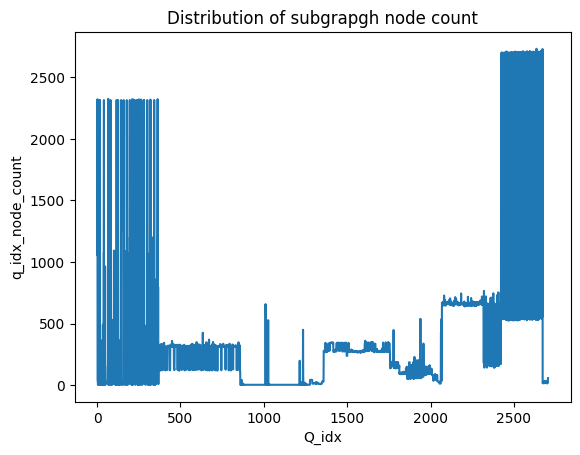

In [15]:
import matplotlib.pyplot as plt
# Plot the distribution
plt.plot(q_idx_node_count[:])
plt.xlabel('Q_idx')
plt.ylabel('q_idx_node_count')
plt.title('Distribution of subgrapgh node count')
plt.show()


In [16]:
shuffled_indices = np.random.permutation(qa_data_builder.question_concepts_answers.index)
shuffled_indices

array([ 254,  584,  610, ..., 1592, 1271, 2244], dtype=int64)

In [150]:
model.train()
limit=1
i=0
for idx in shuffled_indices:
    row = qa_data_builder.question_concepts_answers.loc[idx]
    q_embedding = qa_data_builder.questions_to_embeddings[row["question"]]
    q_x = qa_data_builder.get_x(to_concat=q_embedding)
    q_edge_mask, q_nodes, q_concept_mask, q_answer_mask, q_answer_and_random_nodes_mask =qa_data_builder.get_concepts_and_masks_for_question(question =row["question"], concept_uri= row["concepts"], answer_uri= row["answers"])
    q_edge_index = data.edge_index[:,q_edge_mask]
    q_edge_type = data.edge_type[q_edge_mask]
    q_training_x_mask = qa_data_builder.get_question_training_mask_for_x()
    q_y_labels = qa_data_builder.get_question_y_labels()
    q_data = Data(x=q_x, edge_index=q_edge_index, edge_type=q_edge_type, train_mask=q_training_x_mask, y=q_y_labels)
    print(f'Training for Q {idx} : {row["question"]}')
    for epoch in range(200):
        optimizer.zero_grad()
        out,embedding = model(q_data)
        loss = F.nll_loss(out[q_data.train_mask], q_data.y[q_data.train_mask],weight = torch.tensor([1.0,15.0]))
        loss.backward()
        optimizer.step()
        if epoch%50==0:
            logger.debug(f"Epoch: {epoch:03d}, Loss: {loss:.4f}")
    if i==limit:
        break;
    i+=1

2023-08-23 14:53:34.481 | DEBUG    | __main__:<module>:22 - Epoch: 000, Loss: 0.6827


Training for Q 1649 : Which Business Process is composed of component Supply Chain Strategy Management (Seg17)?


2023-08-23 14:53:36.980 | DEBUG    | __main__:<module>:22 - Epoch: 050, Loss: 0.4489
2023-08-23 14:53:39.315 | DEBUG    | __main__:<module>:22 - Epoch: 100, Loss: 0.4266
2023-08-23 14:53:41.475 | DEBUG    | __main__:<module>:22 - Epoch: 150, Loss: 0.4203
2023-08-23 14:53:43.857 | DEBUG    | __main__:<module>:22 - Epoch: 000, Loss: 0.7682


Training for Q 1613 : The process Sales Execution (ETO, Discrete) (Seg193) is part of which process?


2023-08-23 14:53:46.146 | DEBUG    | __main__:<module>:22 - Epoch: 050, Loss: 0.5016
2023-08-23 14:53:48.391 | DEBUG    | __main__:<module>:22 - Epoch: 100, Loss: 0.4864
2023-08-23 14:53:50.650 | DEBUG    | __main__:<module>:22 - Epoch: 150, Loss: 0.4744


In [23]:
limit=2
i=0
# Evaluation
res = []
for idx in shuffled_indices:
    
    if i==limit:
        break;

    row = qa_data_builder.question_concepts_answers.loc[idx]
    q_embedding = qa_data_builder.questions_to_embeddings[row["question"]]
    q_x = qa_data_builder.get_x(to_concat=q_embedding)
    q_edge_mask, q_nodes, q_concept_mask, q_answer_mask, q_answer_and_random_nodes_mask =qa_data_builder.get_concepts_and_masks_for_question(question =row["question"], concept_uri= row["concepts"], answer_uri= row["answers"])
    q_edge_index = data.edge_index[:,q_edge_mask]
    q_edge_type = data.edge_type[q_edge_mask]
    q_training_x_mask = qa_data_builder.get_question_training_mask_for_x()
    q_y_labels = qa_data_builder.get_question_y_labels()
    q_data = Data(x=q_x,edge_index=q_edge_index,edge_type=q_edge_type,train_mask =q_training_x_mask,y=q_y_labels)
    model.eval()
    print(f'Predicting for Q {idx} : {row["question"]}')
    out,_ = model(q_data)
    predicted_answer_nodes = torch.where(out.argmax(dim=1))[0]
    predicted_answer_node_probabilities = out.max(dim=1)[0][predicted_answer_nodes]
    sorted_probability_indices = torch.argsort(predicted_answer_node_probabilities, descending= True)
    count_predicted_nodes =len(predicted_answer_nodes)
    actual_answer_nodes = q_nodes[q_answer_mask].tolist()
    if count_predicted_nodes > 0:
        logger.debug(f"answers predicted")
        is_predicted_in_actual_answers = bool(set(actual_answer_nodes) & set(predicted_answer_nodes[sorted_probability_indices].tolist()))
        res.append((idx, actual_answer_nodes, predicted_answer_nodes[sorted_probability_indices].tolist(),predicted_answer_node_probabilities[sorted_probability_indices].tolist(),count_predicted_nodes,is_predicted_in_actual_answers))
    
    
    else:
        logger.debug(f"NO answers found")
        res.append((idx, actual_answer_nodes, np.nan,np.nan,0,False))
    
    i+=1

2023-08-23 18:29:11.954 | DEBUG    | __main__:<module>:28 - answers predicted


Predicting for Q 254 : What's an Customer Claims Management?


2023-08-23 18:29:12.277 | DEBUG    | __main__:<module>:28 - answers predicted


Predicting for Q 584 : To which process is Execute projects belonging to?


In [24]:
eval_res = pd.DataFrame.from_records(res,columns=["q_idx","actual_answer_nodes","predicted_answer_nodes","probabilities_of_answer_nodes","count_predicted_nodes","is_predicted_in_actual"])
eval_res

,q_idx,actual_answer_nodes,predicted_answer_nodes,probabilities_of_answer_nodes,count_predicted_nodes,is_predicted_in_actual
0,254,[19288],"[21333, 28099, 7, 6718, 9158, 21334, 1600, 180...","[-0.6863352060317993, -0.6863917112350464, -0....",28974,True
1,584,"[20149, 20150]","[21333, 28099, 7, 6718, 9158, 18843, 21334, 16...","[-0.6844812035560608, -0.6845376491546631, -0....",29025,True


In [147]:
q_idx = 254
#(q_edge_mask, q_nodes, q_concept_mask, q_answer_mask, q_answer_and_random_nodes_mask,q_edge_index,q_edge_type,q_training_x_mask,q_y_labels)
print("Total nodes in the subgraph",len(set(qa_subgraph_info[q_idx]['q_nodes'].tolist())))

len(set(eval_res.loc[eval_res["q_idx"]==q_idx,"predicted_answer_nodes"].iloc[0]) & set(qa_subgraph_info[q_idx]['q_nodes'].tolist()))
#set(eval_res.loc[eval_res["q_idx"]==q_idx,"predicted_answer_nodes"].iloc[0]) & set(qa_subgraph_info[q_idx]['q_nodes'].tolist())

Total nodes in the subgraph 538


14

In [133]:
limit=1
i=0
for idx, row in eval_res.iterrows():
    if row['count_predicted_nodes'] < 30 and row['count_predicted_nodes'] >0 :
        print(f'Question: {qa_data_builder.question_concepts_answers.loc[row["q_idx"],"question"]}')
        print(f'Concepts: {qa_data_builder.question_concepts_answers.loc[row["q_idx"],"concepts"]}')
        print(f'Actual Answer: {row["actual_answer_nodes"]} -- URIs :{qa_data_builder.question_concepts_answers.loc[row["q_idx"],"answers"]}')
        if row["is_predicted_in_actual"]:
            for node in row["predicted_answer_nodes"]:
                
                print(f'Preicted Node: {node} -- URI:{qa_data_builder.index_to_entity[node]}')
        else:
            print("Actua answer is not in the predicted nodes list.")
            for node in row["predicted_answer_nodes"]:
                print(f'Preicted Node: {node} -- URI:{qa_data_builder.index_to_entity[node]}')
    
    if i==limit:
        break;
    i+=1

Question: What's an Customer Claims Management?
Concepts: ['http://www.signavio.com/opal/SAP/RBA/BCM/Customer%20Claims%20Management']
Actual Answer: [19288] -- URIs :['http://www.signavio.com/opal/SAP/RBA/BCM/BusinessCapability']
Actua answer is not in the predicted nodes list.
Preicted Node: 19361 -- URI:http://www.signavio.com/opal/SAP/RBA/BCM/Customer%20Service%20and%20Support
Preicted Node: 20514 -- URI:http://www.signavio.com/opal/SAP/RSA/SCM/Customer%20Claims%20Management%20%28S%204%2C%20Vistex%20S%204%29
Preicted Node: 20512 -- URI:http://www.signavio.com/opal/SAP/RSA/SCM/Customer%20Claims%20Management%20%28S%204%20CLD%29
Preicted Node: 18924 -- URI:http://www.signavio.com/opal/SAP/RBA/BAR/Manage%20customer%20recovery%20claims%20%28BA132%29
Preicted Node: 20513 -- URI:http://www.signavio.com/opal/SAP/RSA/SCM/Customer%20Claims%20Management%20%28S%204%29
Preicted Node: 20508 -- URI:http://www.signavio.com/opal/SAP/RSA/SCM/Customer%20Claims%20Management%20%28C4C%29
Preicted Node: 2